In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [3]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [4]:
from typing import Annotated

from langchain_cohere import ChatCohere
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = ChatCohere(model="command-r-plus")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [5]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [6]:
from typing import Literal


def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

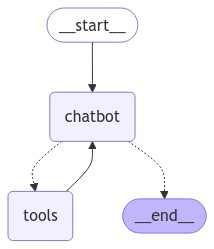

In [7]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "1"}}
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        events = graph.stream(
            {"messages": [("user", user_input)]}, config, stream_mode="values"
        )
        for event in events:
            event["messages"][-1].pretty_print()
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  who won the last wimbledon?


================================ Human Message =================================

who won the last wimbledon?
================================== Ai Message ==================================

I will search for the last Wimbledon winners.
Tool Calls:
  tavily_search_results_json (2293594b785340f5830e48fd9182ae50)
 Call ID: 2293594b785340f5830e48fd9182ae50
  Args:
    query: last wimbledon winners
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.topendsports.com/events/tennis-grand-slam/wimbledon/winners-men.htm", "content": "Here is the winners list of the Wimbledon men's singles event from each year it has been held. The player with the most titles is Roger Federer with eight (2003-2007, 2009, 2012, 2017). Djokovic's win in 2022 was his seventh (and his 21st major singles title overall). Pete Sampras also won Wimbledon 7 times."}, {"url": "https://tennisuptodate.com/wimbledon-list-of-winners", "cont

User:  i don't think it was Novak


================================ Human Message =================================

i don't think it was Novak
================================== Ai Message ==================================

I will search for the last Wimbledon men's singles winner.
Tool Calls:
  tavily_search_results_json (314f976626d146c9b83cb407140e7fd6)
 Call ID: 314f976626d146c9b83cb407140e7fd6
  Args:
    query: last wimbledon men's singles winner
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.sportskeeda.com/tennis/tennis-wimbledon-winners-list", "content": "Last Modified Jul 17, 2023 04:29 GMT. Amateur Era Men's Single Winners - Wimbledon. Year: Winner: Runner-up: 1877: Spencer Gore: William Marshall: 1878: ... Roger Federer in Men's singles (8 ..."}, {"url": "https://www.topendsports.com/events/tennis-grand-slam/wimbledon/winners-men.htm", "content": "Here is the winners list of the Wimbledon men's singles event from each

User:  when was the last Wimbledon


================================ Human Message =================================

when was the last Wimbledon
================================== Ai Message ==================================

I will search for the dates of the last Wimbledon.
Tool Calls:
  tavily_search_results_json (e0e86c4111b142969d46e4854e5d1d12)
 Call ID: e0e86c4111b142969d46e4854e5d1d12
  Args:
    query: last Wimbledon dates
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/Wimbledon_Championships", "content": "Wimbledon; US Open; Last completed; 2024 Wimbledon: The Wimbledon Championships, ... The first full match played and completed under the roof featured Andy Murray and Stan Wawrinka, played on the same date. The court has a capacity of 14,979. At its south end is the Royal Box, from which members of the Royal Family and other dignitaries watch ..."}, {"url": "https://www.bbc.com/sport/tennis/articles/c0

User:  who won at that time?


================================ Human Message =================================

who won at that time?
================================== Ai Message ==================================

I will search for the winners of the 2022 Wimbledon tournament.
Tool Calls:
  tavily_search_results_json (1e622c9565844e70b2909edb557cb904)
 Call ID: 1e622c9565844e70b2909edb557cb904
  Args:
    query: 2022 Wimbledon winners
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.sportskeeda.com/tennis/wimbledon-2022-winners-complete-list-men-s-women-s-singles-doubles-champions", "content": "Novak Djokovic with the 2022 Wimbledon men's singles trophy Novak Djokovic lifted an astonishing seventh Wimbledon trophy on Sunday, getting the better of first-time Grand Slam finalist Nick ..."}, {"url": "https://en.wikipedia.org/wiki/2022_Wimbledon_Championships_\u2013_Men's_singles", "content": "By reaching his 32nd men's singles ma

User:  no, it was alcaraz


================================ Human Message =================================

no, it was alcaraz
================================== Ai Message ==================================

I will search for the winner of the 2022 Wimbledon men's singles.
Tool Calls:
  tavily_search_results_json (a6a051062c3b4258a479a489fe3dc595)
 Call ID: a6a051062c3b4258a479a489fe3dc595
  Args:
    query: 2022 wimbledon men's singles winner
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://en.wikipedia.org/wiki/2022_Wimbledon_Championships_\u2013_Men's_singles", "content": "By reaching his 32nd men's singles major final, he surpassed Roger Federer's all-time record.[3] Djokovic also became the first player (male or female) to win 80 matches at all four majors with his first-round win over Kwon Soon-woo.[4] Because no ranking points were awarded for the tournament in response to its banning of Russian and Belarusian players, D

User:  who won in 2024?


================================ Human Message =================================

who won in 2024?
================================== Ai Message ==================================

I will search for the winner of the 2024 Wimbledon men's singles.
Tool Calls:
  tavily_search_results_json (2f8f96f3a4514612821c4bbb1d894482)
 Call ID: 2f8f96f3a4514612821c4bbb1d894482
  Args:
    query: 2024 wimbledon men's singles winner
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.cbssports.com/tennis/news/wimbledon-tennis-championships-2024-results-winners-scores-highlights-bracket-complete-guide/", "content": "The 2024 Wimbledon Championships have officially wrapped up with Carlos Alcaraz as the men's singles winner. He won his second consecutive title with a 6-2, 6-2, 7-6 (7-4) win over 24-time Grand ..."}, {"url": "https://www.sportingnews.com/us/tennis/news/alcaraz-djokovic-live-score-result-highlights-wimbled

User:  yes


================================ Human Message =================================

yes
================================== Ai Message ==================================

Yes.


In [ ]:
snapshot = graph.get_state(config)
snapshot